In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics

In [2]:
#dados das eleições de 2006 e 2010
train = pd.read_csv("../data/train.csv")
#dados das eleições de 2014
test = pd.read_csv("../data/test.csv")

# dumy da variável alvo, eleito = 1 e nao_eleito = 0
y = train["situacao"]
y = y.replace(['nao_eleito', 'eleito'], [0, 1])

#removendo variável alvo dos dados de treino
train = train.drop(columns=['situacao'])
#merge treino e teste
data = pd.concat((train, test))
#removendo variáveis irrelevantes
data = data.drop(columns=['sequencial_candidato', 'nome', 'cargo',
                            'quantidade_doacoes', 'total_receita',
                            'quantidade_despesas', 'total_despesa'])

#selecionando atributos numéricos
attr_num = data.dtypes[data.dtypes != "object"].index
#normalizando variáveis numéricas exceto ano
data[attr_num[1:]] = np.log1p(data[attr_num[1:]])

#dummy das variáveis categoricas
data = pd.get_dummies(data)

x = data.loc[data['ano'] != 2014]
test = data.loc[data['ano'] == 2014]

### 1- Há desbalanceamento das classes (isto é, uma classe tem muito mais instâncias que outra)? Em que proporção? Quais efeitos colaterais o desbalanceamento de classes pode causar no classificador? Como você poderia tratar isso?

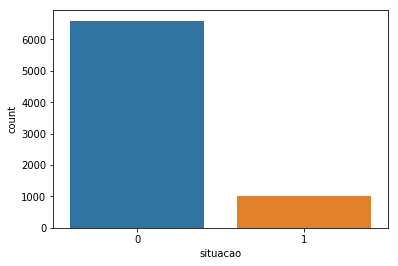

In [3]:
#plotando distribuição da variável alvo
sns.countplot(y)            

As classes estão claramente desbalanceadas, essa diferença pode enviesar a aprendizagem dos modelos. Isso pode ser tratrado por meio de técnicas de `Under-sampling`, neste caso vou utilizar a técnica NearMiss versão 2, que seleciona as amostras da classe majoritária para as quais a distância média até as N-amostras mais distantes da classe minoritária é a menor.

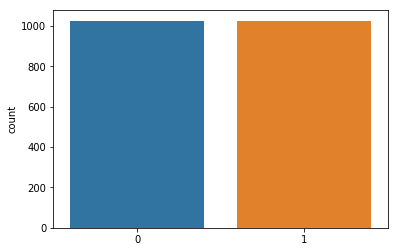

In [4]:
#balanceando as classes
from imblearn.under_sampling import NearMiss
nm = NearMiss(version=2)
x_balanced, y_balanced = nm.fit_resample(x, y)
#plotando distribuição da variável alvo
sns.countplot(y_balanced)

### 2) Treine: um modelo de regressão logística, KNN, uma árvore de decisão e um modelo de adaboost. Tune esses modelos usando validação cruzada e controle overfitting se necessário, considerando as particularidades de cada modelo.
A função NearMiss agrupa os dados em suas respectivas classes assim é preciso realizar um shuffle ao selecionar os folds 

In [5]:
#Função para calcular o f1 na validação cruzada
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
def report_cv(model, x, y):
    f1 = cross_val_score(model, x, y, scoring='f1', cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=3058))
    return(f1)

#### Logistic Regression

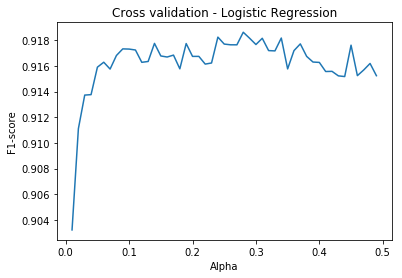

O melhor alpha é 0.28, com F1 = 0.9186280039090351


In [6]:
from sklearn.linear_model import LogisticRegression
alphas = np.arange(0.01,0.5,0.01).tolist()
cv_logRegression = [report_cv(LogisticRegression(solver="lbfgs", max_iter=10000, C=alpha),
                         x_balanced, 
                         y_balanced).mean()
                    for alpha in alphas]
cv_logRegression = pd.Series(cv_logRegression, index = alphas)
#plot do f1 na validação cruzada
cv_logRegression.plot(title = "Cross validation - Logistic Regression")
plt.xlabel("Alpha")
plt.ylabel("F1-score")
plt.show()
print("O melhor alpha é {0}, com F1 = {1}".format(cv_logRegression.idxmax(), cv_logRegression.max()))

#### KNN

A melhor quantidade de vizinhos é 23, com F1 = 0.9055373656085501


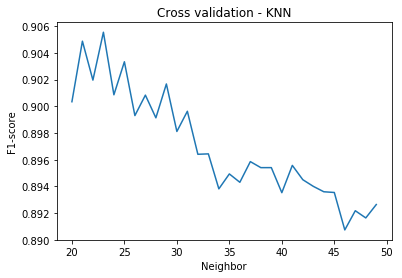

In [7]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.neighbors import KNeighborsClassifier
neighbors = np.arange(20,50,1).tolist()
cv_knn = [report_cv(KNeighborsClassifier(n_neighbors=neighbor),
               x_balanced,
               y_balanced).mean() 
            for neighbor in neighbors]
cv_knn = pd.Series(cv_knn, index = neighbors)
#plot do f1 na validação cruzada
cv_knn.plot(title = "Cross validation - KNN")
plt.xlabel("Neighbor")
plt.ylabel("F1-score")
print("A melhor quantidade de vizinhos é {0}, com F1 = {1}".format(cv_knn.idxmax(), cv_knn.max()))

#### Árvore de Decisão

A profundidade máxima ideal é 8, com F1 = 0.8849092993610764


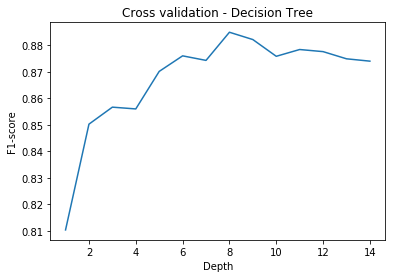

In [8]:
from sklearn.tree import DecisionTreeClassifier
depths = np.arange(1,15,1).tolist()
cv_tree = [report_cv(DecisionTreeClassifier(max_depth = depth),
                x_balanced,
                y_balanced).mean() 
            for depth in depths]
cv_tree = pd.Series(cv_tree, index = depths)
#plot do f1 na validação cruzada
cv_tree.plot(title = "Cross validation - Decision Tree")
plt.xlabel("Depth")
plt.ylabel("F1-score")
print("A profundidade máxima ideal é {0}, com F1 = {1}".format(cv_tree.idxmax(), cv_tree.max()))

#### Adaboost
Para o parâmetro max_depth utilizei a profundidade ideal encontrada para árvore de decisão.

A quantidade de árvores ideal é 43, com F1 = 0.9245185661890675


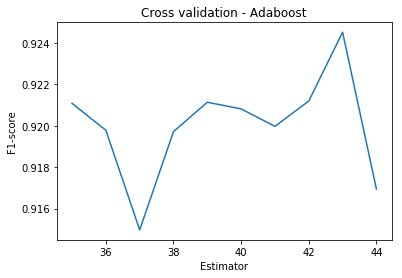

In [9]:
from sklearn.ensemble import AdaBoostClassifier
estimators = np.arange(35,45,1).tolist()
cv_ada =  [report_cv(AdaBoostClassifier(DecisionTreeClassifier(max_depth=cv_tree.idxmax()), 
                                    algorithm="SAMME", 
                                    n_estimators=estimator),
                x_balanced,
                y_balanced).mean() 
            for estimator in estimators]
cv_ada = pd.Series(cv_ada, index = estimators)
#plot do f1 na validação cruzada
cv_ada.plot(title = "Cross validation - Adaboost")
plt.xlabel("Estimator")
plt.ylabel("F1-score")
print("A quantidade de árvores ideal é {0}, com F1 = {1}".format(cv_ada.idxmax(), cv_ada.max()))

### 3) Reporte Precision, Recall e AUC-Precision&Recall no treino e validação. Há uma grande diferença de desempenho no treino/validação? Como você avalia os resultados? Justifique sua resposta.

Função para calcular métricas no treino e validação

In [10]:
from sklearn.model_selection import KFold
def report_train_validation(model,x,y):
    kf = KFold(n_splits=5, random_state=None, shuffle=True)
    for train_index, validation_index in kf.split(x_balanced):
        model.fit(x[train_index,:], y[train_index])
        #report train
        predicts_train = model.predict(x[train_index,:])
        report_train = metrics.classification_report(y[train_index], predicts_train, output_dict=True)["macro avg"]
        #report validation
        predicts_validation = model.predict(x[validation_index,:])
        report_validation = metrics.classification_report(y[validation_index], predicts_validation, 
                                                         output_dict=True)["macro avg"]
        #print metrics
        print("Precision = train:{0} - validation:{1}".format(report_train["precision"], report_validation["precision"]))
        print("Recall = train:{0} - validation:{1}".format(report_train["recall"], report_validation["recall"]))
        print("AUC-Precision&Recall = train:{0} - validation:{1}".format(report_train["f1-score"], report_validation["f1-score"]))
        return 

Reportando métricas no treino e na validação

In [11]:
log_reg = LogisticRegression(solver="lbfgs", max_iter=10000, C=cv_logRegression.idxmax())
print("Logistic Regression")
report_train_validation(log_reg, x_balanced, y_balanced)

Logistic Regression
Precision = train:0.9244798552537368 - validation:0.9249490013757768
Recall = train:0.9244609392639422 - validation:0.9243450660855559
AUC-Precision&Recall = train:0.9244360667718332 - validation:0.9245098562007857


In [12]:
knn = KNeighborsClassifier(n_neighbors=cv_knn.idxmax())
print("KNN")
report_train_validation(knn, x_balanced, y_balanced)

KNN
Precision = train:0.9127497202536368 - validation:0.9206793491152332
Recall = train:0.9109324820933611 - validation:0.9200217885562714
AUC-Precision&Recall = train:0.9109223864082522 - validation:0.9196909139355183


In [13]:
tree = DecisionTreeClassifier(max_depth = cv_tree.idxmax())
print("Decision Tree")
report_train_validation(tree, x_balanced, y_balanced)

Decision Tree
Precision = train:0.9684388837706915 - validation:0.8787135749822317
Recall = train:0.9682802343406496 - validation:0.878641811549576
AUC-Precision&Recall = train:0.9683077563026459 - validation:0.8783447785934171


In [14]:
ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=cv_tree.idxmax()), 
                                    algorithm="SAMME", 
                                    n_estimators=cv_ada.idxmax())
print("AdaBoost")
report_train_validation(ada, x_balanced, y_balanced)

AdaBoost
Precision = train:1.0 - validation:0.9291943127962086
Recall = train:1.0 - validation:0.9296218985720386
AUC-Precision&Recall = train:1.0 - validation:0.9293584234701437


As métricas no treino são melhores do que na validação para todos os casos, conforme esperado. Os modelos tem melhor ajuste aos folds que foram usados no seus treinamentos, por isso métricas extraidas dos dados de treino não expressam a capacidade de generalização do modelo. 

### 4) Interprete as saídas dos modelos. Quais atributos parecem ser mais importantes de acordo com cada modelo?

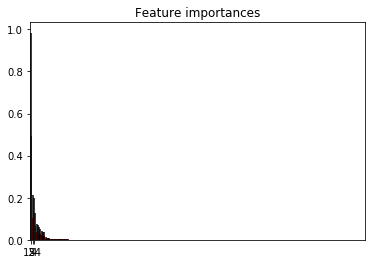

In [90]:
# print(tree.feature_importances_.
# print(data.columns.values[5])


importances = tree.feature_importances_
indices = np.argsort(importances)[::-1]



# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(data.shape[1]), importances[indices],
       color="r", yerr=importances[indices], align="center")
plt.xticks(range(data.shape[1])[0:3], indices[0:3])
plt.xlim([-1, data.shape[1]])
plt.show()


### 5) Envie seus melhores modelos à competição do Kaggle.

### Testando Outros Modelos

#### Random Forest

Novamente, para o parâmetro max_depth utilizei a profundidade ideal encontrada para árvore de decisão

A quantidade de árvores ideal é 119, com F1 = 0.9112322893509119


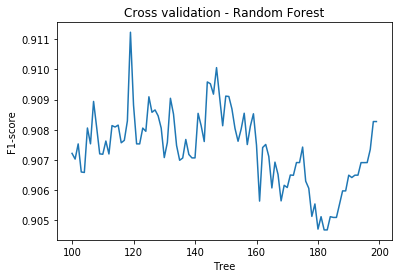

In [16]:
from sklearn.ensemble import RandomForestClassifier
trees = np.arange(100,200,1).tolist()
cv_random_forest = [report_cv(RandomForestClassifier(n_estimators=tree, max_depth=cv_tree.idxmax(), random_state=0),
                         x_balanced,
                         y_balanced).mean() 
                    for tree in trees]
cv_random_forest = pd.Series(cv_random_forest, index = trees)
#plot do AUC-Precision&Recall na validação cruzada
cv_random_forest.plot(title = "Cross validation - Random Forest")
plt.xlabel("Tree")
plt.ylabel("F1-score")
print("A quantidade de árvores ideal é {0}, com F1 = {1}".format(cv_random_forest.idxmax(), cv_random_forest.max()))

Modelos lineares não sofrem enviesamento por desbalanceamento de classes, então vou tunar o modelo de `regressão logistíca` novamente desta vez considerando os dados não balanceados.

#### Logistic Regression

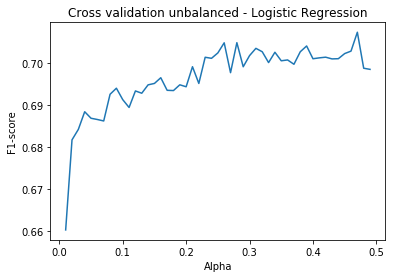

O melhor alpha é 0.47000000000000003, com F1 = 0.7073541322399917


In [19]:
from sklearn.linear_model import LogisticRegression
alphas = np.arange(0.01,0.5,0.01).tolist()
cv_logRegression = [report_cv(LogisticRegression(solver="lbfgs", max_iter=10000, C=alpha),
                         x, 
                         y).mean()
                    for alpha in alphas]
cv_logRegression = pd.Series(cv_logRegression, index = alphas)
#plot do f1 na validação cruzada
cv_logRegression.plot(title = "Cross validation unbalanced - Logistic Regression")
plt.xlabel("Alpha")
plt.ylabel("F1-score")
plt.show()
print("O melhor alpha é {0}, com F1 = {1}".format(cv_logRegression.idxmax(), cv_logRegression.max()))

Após realizar algumas submissões percebi que o score estimado para qualquer modelo considerando seu melhor hiperparametro é bem diferente do estimado pelo Kaggle. Uma possível causa para isso é que a distribuição dos dados das eleições de 2006 e 2010 é diferente da distribuição da eleição de 2014. 

O modelo que obteve o melhor score no kaggle foi a regressão logistíca. Analisando os atributos mais importantes de cada modelo percebi que muitos atributos não eram descartados pelos modelos de classificação. 

Deste modo, sabendo que os dados possívelmente são linearmente separáveis, já que no kaggle a regressão foi a melhor, resolvi utilizar uma regressão logística com norma l1 para penalisar os atributos menos importantes.

#### Regressão Logistíca L1

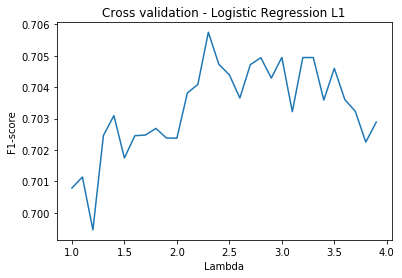

O melhor alpha é 2.300000000000001, com F1 = 0.7057452479485221


In [17]:
from sklearn.linear_model import LogisticRegression
lambdas = np.arange(1,4,0.1).tolist()
cv_logRegression = [report_cv(LogisticRegression(penalty='l1', solver='liblinear', max_iter=10000, C=lbd, random_state=1), 
                          x, y).mean()
                    for lbd in lambdas]
cv_logRegression = pd.Series(cv_logRegression, index = lambdas)
#plot do AUC-Precision&Recall na validação cruzada
cv_logRegression.plot(title = "Cross validation - Logistic Regression L1")
plt.xlabel("Lambda")
plt.ylabel("F1-score")
plt.show()
print("O melhor alpha é {0}, com F1 = {1}".format(cv_logRegression.idxmax(), cv_logRegression.max()))

Assim, os atributos sem importância perderam influência na aprendizagem o modelo. A regressão logistíca com norma L1 obteve o melhor score no kaggle.

### Submission

In [18]:
submission = pd.read_csv("../data/sample_submission.csv")
m = LogisticRegression(penalty='l1', solver='liblinear', max_iter=10000, C=lbd, random_state=1)
m.fit(x, y)
predicts_submission = pd.DataFrame(m.predict(test))
predicts_submission = predicts_submission.replace([0, 1],['nao_eleito', 'eleito'])
submission["Predicted"] = predicts_submission
submission.to_csv("../data/sample_submission.csv", index=False)